In [55]:
################################################################################
###   importing of packages
################################################################################

# basic packages
import pandas as pd
import numpy as np

# packages for the webdriver keys
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


In [56]:
################################################################################
###   setting some configurations
################################################################################
pd.set_option('display.max_columns', None)

import os
path = r'C:\Users\eight\Desktop\Kelvin HDD\3. Coursera\2. Python\Python Notes\Webscrapping'
os.chdir(path)

In [64]:
################################################################################
###   launch Google chrome
################################################################################
# launches chrome
driver = webdriver.Chrome('chromedriver.exe')  

# launches the website automatically; "https" is a must to be included
url = 'https://sg.hotels.com/search.do?resolved-location=COUNTRY%3A10233092%3AUNKNOWN%3AUNKNOWN&destination-id=10233092&q-destination=Laos&q-check-in=2019-12-12&q-check-out=2019-12-13&q-rooms=1&q-room-0-adults=2&q-room-0-children=0'
driver.get(url)  

################################################################################
###   create the XPath codes
################################################################################

for i in range(1,40):
	time.sleep(1)	
	driver.execute_script("window.scrollTo(0,({}/100)*(document.body.scrollHeight));".format(max(75+i,85)))
	
prop = []; review = []; price = []; star = []; review_num = []		
xpath = "//section[div/div/div[@class='reviews-box resp-module']]"

# for the property	
property_list = driver.find_elements_by_xpath(xpath + "/div/h3[@class='p-name']")

# for the prices
price_list = driver.find_elements_by_xpath(xpath + "/aside//strong | " + xpath + "/aside//ins")

# for the reviews
review_list = driver.find_elements_by_xpath(xpath + "//strong[contains(@class, 'guest-reviews-badge')]")	

# for the hotels.com number of reviews
num_reviews_list = driver.find_elements_by_xpath(xpath + "//span[contains(@class,'full-view')]")

################################################################################
###   create the dataframes
################################################################################

[prop.append(i.text) for i in property_list]
[price.append(i.text) for i in price_list]
[review_num.append(rev_num.text) for rev_num in num_reviews_list]
[review.append(i.text) for i in review_list]	

prop = pd.DataFrame(prop)
price = pd.DataFrame(price)
review_num = pd.DataFrame(review_num)
review = pd.DataFrame(review)

df = pd.concat([prop, price, review_num, review], axis=1)
df.columns = ["hotel_name", "price", "num_reviews", "rating"]

print(df.hotel_name.isna().sum())
print(df.num_reviews.isna().sum())
print(df.rating.isna().sum())
print(df.price.isna().sum())

print(df)

0
0
0
0
                       hotel_name  price                   num_reviews  \
0          Crowne Plaza Vientiane   S$92  252 Hotels.com guest reviews   
1                        AV Hotel   S$40   23 Hotels.com guest reviews   
2         NT backpackers - Hostel    S$6    4 Hotels.com guest reviews   
3                 Villa Tavandang   S$39     1 Hotels.com guest review   
4         Jasmine Vangvieng Hotel   S$43   36 Hotels.com guest reviews   
5                       Mixok Inn   S$22   50 Hotels.com guest reviews   
6           Chanthasom Guesthouse   S$31    3 Hotels.com guest reviews   
7                Mixok Guesthouse   S$22    8 Hotels.com guest reviews   
8              Mittaphap Hotel II   S$39    2 Hotels.com guest reviews   
9           Family Boutique Hotel   S$44  186 Hotels.com guest reviews   
10        Chandara Boutique Hotel   S$55   24 Hotels.com guest reviews   
11              Thawee Guesthouse   S$21    5 Hotels.com guest reviews   
12        Kiridara Villa Ban K

In [75]:
################################################################################
###   further processing of data
################################################################################
import re

# create new function for the num_reviews column
split_num_review = lambda x : re.findall("\d+", x)[0]
df["num_reviews_cleaned"] = df.num_reviews.apply(split_num_review)

# create new function for the rating column
split_rating = lambda x : re.findall("\d+.\d+", x)[0]
df["rating_cleaned"] = df.rating.apply(split_rating)

# create new function for the price column
split_price = lambda x : re.findall("\d+", str(x))[0]
df["price_cleaned"] = df.price.apply(split_price)
# for i in range(len(df.price)-1):
#     df.price_cleaned[i] = df.price_cleaned[i][0]

# change the types of the columns
df.num_reviews_cleaned = df.num_reviews_cleaned.astype(np.int64)
df.rating_cleaned = df.rating_cleaned.astype(np.float64)
df.price_cleaned = df.price_cleaned.astype(np.int64)
df.dtypes

hotel_name              object
price                   object
num_reviews             object
rating                  object
num_reviews_cleaned      int64
rating_cleaned         float64
price_cleaned            int64
dtype: object

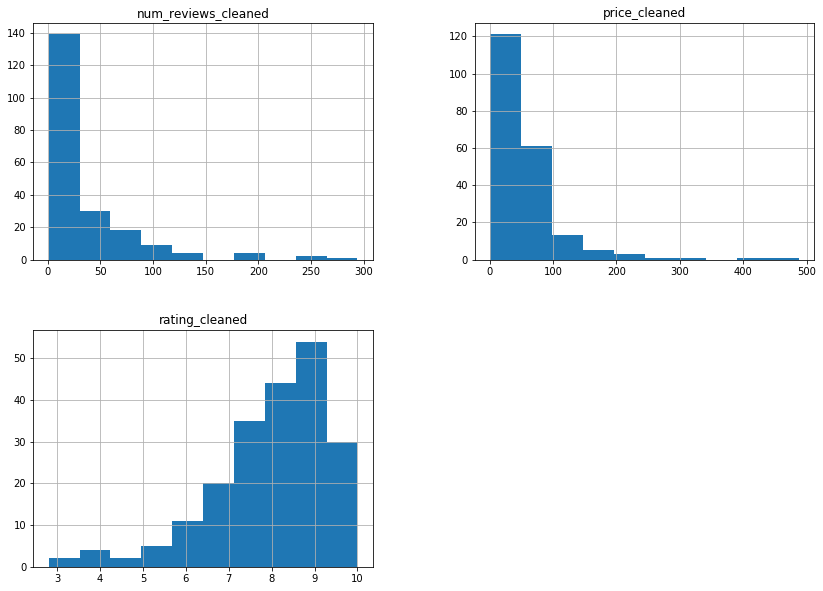

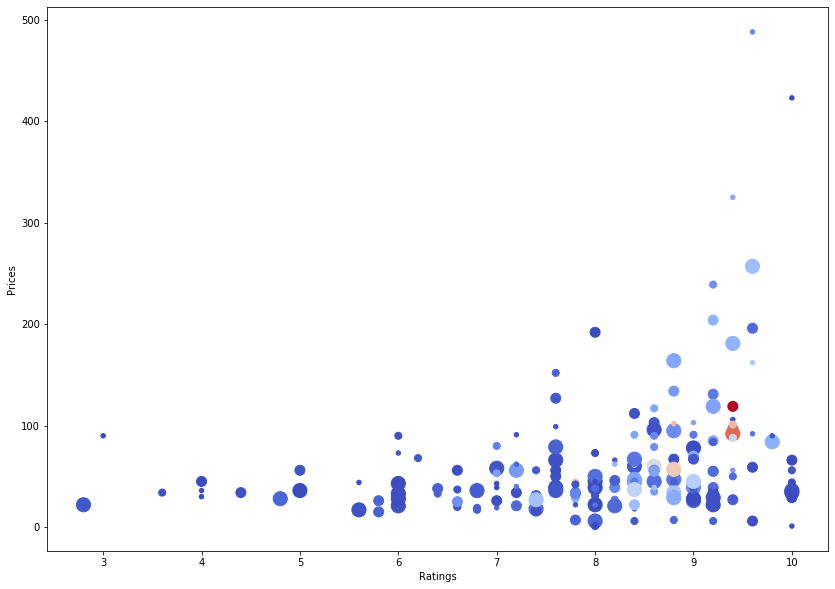

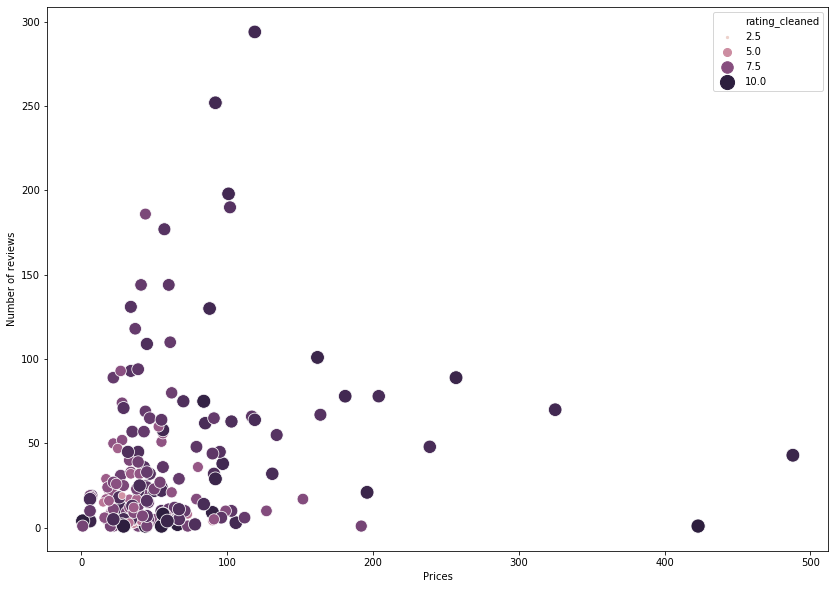

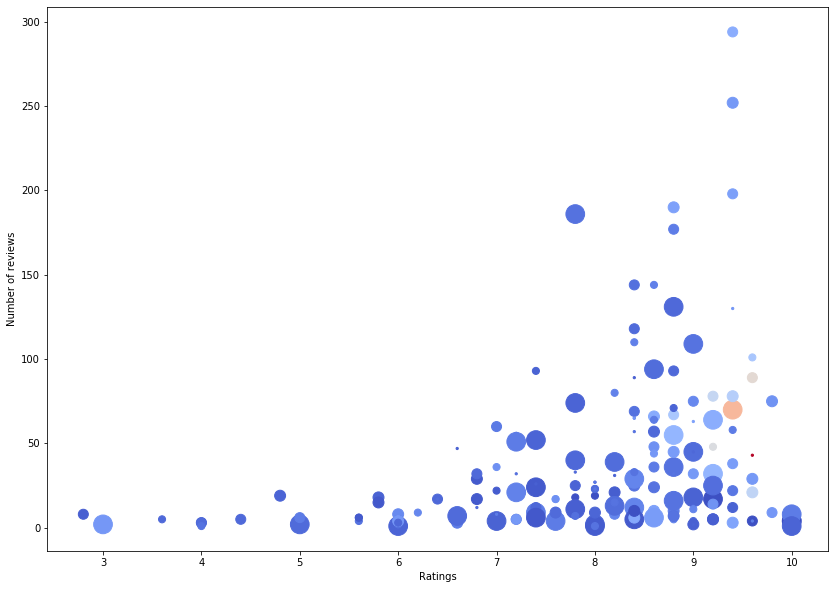

In [76]:
################################################################################
###   data visualisation
################################################################################
import seaborn as sns
import matplotlib.pyplot as plt

# all histograms
pd.DataFrame.hist(df, figsize = (14,10))

# rating against price
plt.figure(figsize = (14,10))
plt.scatter(df.rating_cleaned, df.price_cleaned, 
			c = df.num_reviews_cleaned, 
			s = df.num_reviews_cleaned, 
			sizes = (20, 50, 100, 200), cmap = 'coolwarm')
plt.xlabel('Ratings')
plt.ylabel('Prices')
plt.show()


# price against number of reviews
plt.figure(figsize = (14,10))
sns.scatterplot(df.price_cleaned, df.num_reviews_cleaned,
				hue = df.rating_cleaned,
				size = df.rating_cleaned,
				sizes = (5, 200), cmap = 'coolwarm')
plt.xlabel('Prices')
plt.ylabel('Number of reviews')
plt.show()

# rating against number of reviews
plt.figure(figsize = (14,10))
plt.scatter(df.rating_cleaned, df.num_reviews_cleaned,
			c = df.price_cleaned, 
			s = df.price_cleaned, 
			sizes = (5, 50, 100, 120, 350), cmap = 'coolwarm')
plt.xlabel('Ratings')
plt.ylabel('Number of reviews')
plt.show()


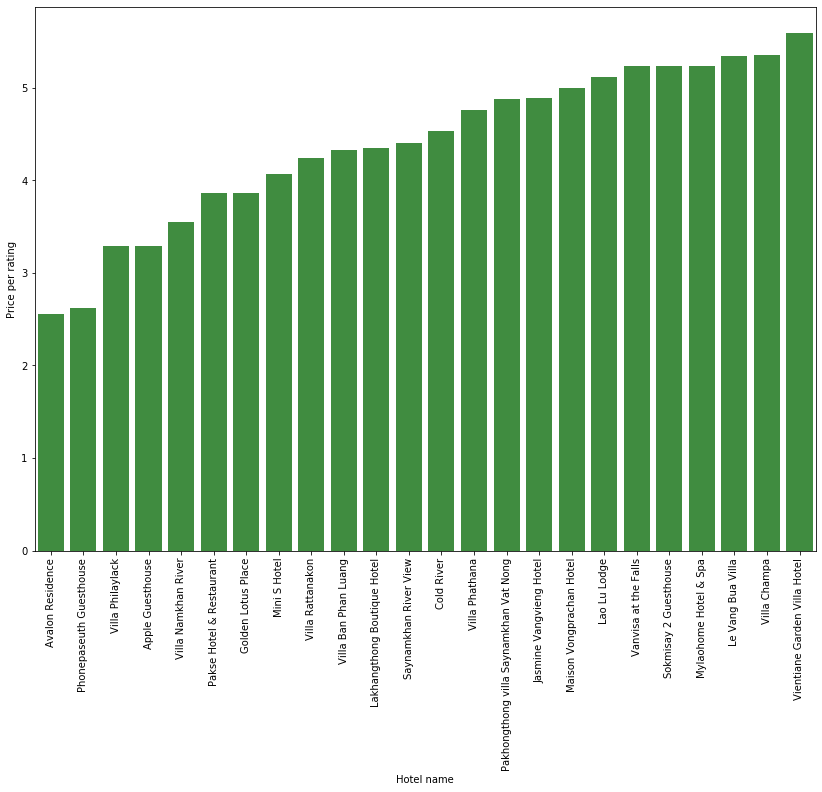

In [83]:
# examine the price per rating
# the lower the ratio, the better
df["price_per_rating"] = df.price_cleaned / df.rating_cleaned
df = df.sort_values(by=['price_per_rating'], ascending = True)

# we limit the search based on some criteria
df_select = df.loc[(df['num_reviews_cleaned'] > 20) & 
				   (df['price_cleaned'] < 50) & 
				   (df['rating_cleaned'] > 8)]

# lets plot the graph
plt.figure(figsize = (14,10))
sns.barplot(df_select.hotel_name.head(50), df_select.price_per_rating.head(50), 
            alpha = 0.8, color = 'green')
plt.xticks(rotation = 'vertical')
plt.xlabel('Hotel name')
plt.ylabel('Price per rating')
plt.show()


In [87]:
# which are the top 10, sorted by ratings then number of reviews
df_select.sort_values(by = ['num_reviews_cleaned', 'rating_cleaned'], ascending = False)

,hotel_name,price,num_reviews,rating,num_reviews_cleaned,rating_cleaned,price_cleaned,price_per_rating
72,Pakhongthong villa Saynamkhan Vat Nong,S$41,144 Hotels.com guest reviews,Very good 8.4,144,8.4,41,4.880952
24,Golden Lotus Place,S$34,131 Hotels.com guest reviews,Fabulous 8.8,131,8.8,34,3.863636
187,Saynamkhan River View,S$37,118 Hotels.com guest reviews,Very good 8.4,118,8.4,37,4.404762
99,Maison Vongprachan Hotel,S$45,109 Hotels.com guest reviews,Superb 9.0,109,9.0,45,5.000000
204,Cold River,S$39,94 Hotels.com guest reviews,Fabulous 8.6,94,8.6,39,4.534884
27,Pakse Hotel & Restaurant,S$34,93 Hotels.com guest reviews,Fabulous 8.8,93,8.8,34,3.863636
150,Phonepaseuth Guesthouse,S$22,89 Hotels.com guest reviews,Very good 8.4,89,8.4,22,2.619048
151,Apple Guesthouse,S$29,71 Hotels.com guest reviews,Fabulous 8.8,71,8.8,29,3.295455
107,Mylaohome Hotel & Spa,S$44,69 Hotels.com guest reviews,Very good 8.4,69,8.4,44,5.238095
135,Vientiane Garden Villa Hotel,S$47,65 Hotels.com guest reviews,Very good 8.4,65,8.4,47,5.595238
